---
### *The 11th Computational Neuroscience Winter School*
# Tutorial II: Introduction to Brian : Simulation of Spiking Neuronal Network
---
__Date:__ Jan. 21, 2022

__Content Creator:__ Kai Chen, Ziling Wang

***Reference:** https://brian2.readthedocs.io/en/stable/*


# Tutorial Objectives:

1. Get started for Brian2 modeling framework.
    1. Unit system
    1. Simulate individual neuron
    1. Build a structured network and run simulation.
1. Explore different types of integrate-and-fire networks.
    1. Current-based
    1. Conductance-based

# Setup

In [1]:
# @title Import most modules and functions needed
import time
import numpy as np 
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 18
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

---
#### Brian2 Installation
Reference: https://brian2.readthedocs.io/en/stable/introduction/install.html

You can either install Brian 2 in the Anaconda root environment, or [create a new environment](https://conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html) for Brian 2. The latter has the advantage that you can update (or not update) the dependencies of Brian 2 independently from the rest of your system.

```bash
$ conda install -c conda-forge brian2
```

*Note: Brian 2 is not part of the main Anaconda distribution, but built using the community-maintained conda-forge project. You will therefore have to to install it from the conda-forge channel, as shown above.*

---

All Brian scripts start with the following. If you're trying this notebook out in the Jupyter notebook, you should start by running this cell.

In [2]:
from brian2 import *

Later we'll do some plotting in the notebook, so we activate inline plotting in the notebook by doing this:

---
# Units system

Brian has a system for using quantities with physical dimensions:

In [3]:
20*volt

20. * volt

All of the basic SI units can be used (`volt`, `amp`, `second`, etc.) along with all the standard prefixes (m=milli, p=pico, etc.), as well as a few special abbreviations like ``mV`` for millivolt, ``pF`` for picofarad, etc.

In [4]:
1000*amp

1. * kamp

In [5]:
1e6*ms

1. * ksecond

In [6]:
1000*namp

1. * uamp

Also note that combinations of units with work as expected:

In [7]:
10*nA*5*Mohm

50. * mvolt

And if you try to do something wrong like adding amps and volts, what happens?

---
# A simple model: Leakly Integrate-and-Fire Neuron
The membrane potential equation for the LIF is given by
\begin{eqnarray}
C_m\frac{dV}{dt} = -g_L(V-V_L) + I
\end{eqnarray}
$I$ is a driving current. $C_m$ is the membrane capacitance of the neuron. We also assume the membrane only has a leak conductance $g_L$, trying to bring the voltage to leak potential $V_L$. 

Dividing both sides of the equation by $g_L$ we get,
\begin{align}
\tau_m\frac{dV}{dt} = -(V-V_L) + \frac{I}{g_L}\,,\quad (1)
\end{align}
where $\tau_m=C/g_L$.

If $I$ is sufficiently strong such that $V$ reaches some threshold value $V_{th}$, $V$ will be reset to a reset potential $V_{reset}<V_{th}$, i.e.,

\begin{eqnarray}
\mathrm{if}\quad V(t)\geq V_{th}&:& V(t^+)=V_{reset}
\end{eqnarray}

Let's start by defining a simple neuron model. In Brian, all models are defined by systems of differential equations. Here's a simple example of what that looks like:

In [8]:
start_scope()    # exclude previously defined Brian objects

# Dimension-free model parameters
tau_m   = 10*ms  # membrane time constant
E_l     = 0      # leaky reversal potential
V_thred = 1      # threshold potential
V_rest  = 0      # resting potential
g_l     = 0.05   # leaky conductance

# define ordinary differential equation for LIF model
eqs = '''
dv/dt = ((E_l - v) + I/g_l)/tau_m : 1 (unless refractory)
I : 1
'''

# create neuron group consisting one LIF neuron
G = NeuronGroup(1, eqs, threshold='v>V_thred', reset='v=V_rest', refractory=2*ms, method='exact')
state_monitor = StateMonitor(G, 'v', record=True)   # define monitor to tracking membrane potential
spike_monitor = SpikeMonitor(G)                     # define monitor to record spike events
G.I=8e-2   # set constant external current input

print('Before v = %s' % G.v[0])
run(30*ms)     # run simulation for 30 ms
print('After v = %s' % G.v[0])

Before v = 0.0
After v = 0.7563321215311216


In Python, the notation ``'''`` is used to begin and end a multi-line string. So the equations are just a string with one line per equation. The equations are formatted with standard mathematical notation, with one addition. At the end of a line you write ``: unit`` where ``unit`` is the SI unit of that variable.
Note that this is not the unit of the two sides of the equation (which would be ``1/second``), but the unit of the *variable* defined by the equation, i.e. in this case $v$.

First off, ignore that ``start_scope()`` at the top of the cell. You'll see that in each cell in this tutorial where we run a simulation. All it does is make sure that any Brian objects created before the function is called aren't included in the next run of the simulation.

`method` represents the method we chose to solve the ODE system. It's ok and accurate if you choose `exact`, meaning exact analytical solution. Other methods, such as `euler` and `rk4`, corresponding to forward euler and 4th order Runge-Kutta schemes, are commenly used to in numerical simulations of large networks. 

In this example, we used the object ``StateMonitor`` object. This is used to record the values of a neuron variable while the simulation runs. The first two arguments are the group to record from, and the variable you want to record from. We also specify ``record=0``. This means that we record all values for neuron 0. We have to specify which neurons we want to record because in large simulations with many neurons it usually uses up too much RAM to record the values of all neurons.

Well, the command ``run(30*ms)`` runs the simulation for 30 ms.

Now let's take a look at a graph of how the variable ``v`` evolves over time.

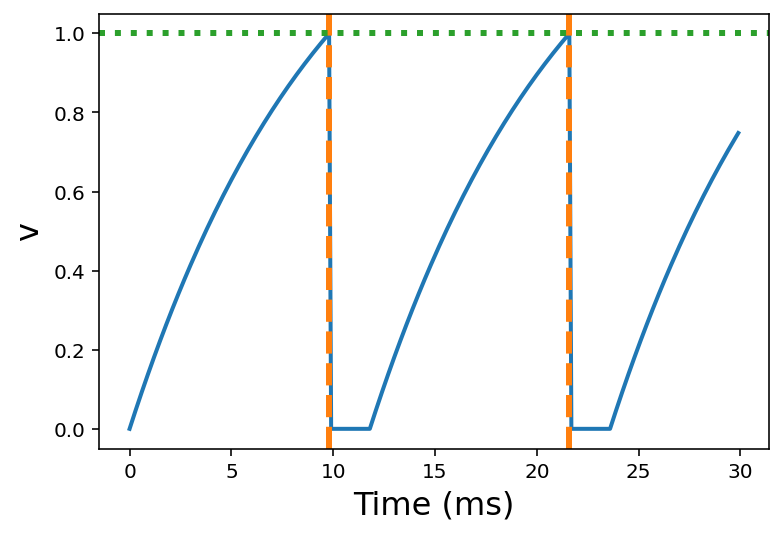

In [9]:
# plot membrane potential trace
plot(state_monitor.t/ms, state_monitor.v[0])
for t in spike_monitor.t:
    axvline(t/ms, ls='--', c='C1', lw=3)   # using matplotlib.pyplot.axvline to indicate spike times
axhline(V_thred, ls=':', c='C2', lw=3)
xlabel('Time (ms)')
ylabel('v');

#### Threshold and Reset
Since we've added two important keywords to the ``NeuronGroup`` declaration: ``threshold='v>V_thred'`` and ``reset='v = V_rest'``. What this means is that when ``v>V_thred`` we fire a spike, and immediately reset ``v = V_rest`` after the spike. We can put any expression and series of statements as these strings.

As you can see, at the beginning the behaviour is the same as before until ``v`` crosses the threshold ``v>0.8`` at which point you see it reset to 0. You can't see it in this figure, but internally Brian has registered this event as a spike. Let's have a look at that.

The ``SpikeMonitor`` object takes the group whose spikes you want to record as its argument and stores the spike times in the variable ``t``. Let's plot those spikes on top of the other figure to see that it's getting it right.

Now try playing with the strings for ``threshold`` and ``reset`` in the cell above to see what happens.

#### Refractoriness
A common feature of neuron models is refractoriness. This means that after the neuron fires a spike it becomes refractory for a certain duration and cannot fire another spike until this period is over. Here's how we do that in Brian.

As you can see in this figure, after the first spike, ``v`` stays at 0 for around 2 ms before it resumes its normal behaviour. To do this, we've done two things. Firstly, we've added the keyword ``refractory=2*ms`` to the ``NeuronGroup`` declaration. On its own, this only means that the neuron cannot spike in this period (see below), but doesn't change how ``v`` behaves. In order to make ``v`` stay constant during the refractory period, we have to add ``(unless refractory)`` to the end of the definition of ``v`` in the differential equations. What this means is that the differential equation determines the behaviour of ``v`` unless it's refractory in which case it is switched off.

## Multiple neurons

So far we've only been working with a single neuron. Let's do something interesting with multiple neurons.

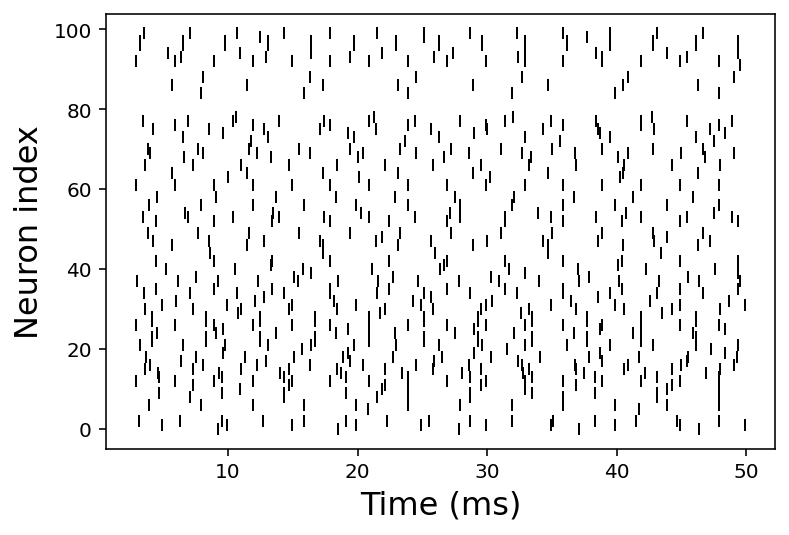

In [10]:
start_scope()

N = 100
tau_m = 10*ms
E_l = 0
V_thred = 1
V_rest  = 0
g_l = 0.05

eqs = '''
dv/dt = ((E_l - v) + I/g_l)/tau_m : 1
I : 1
'''

G = NeuronGroup(N, eqs, threshold='v>V_thred', reset='v=V_rest', method='exact')
state_monitor = StateMonitor(G, 'v', record=True)
spike_monitor = SpikeMonitor(G)
I_max = 2e-1
G.I = 'I_max*rand()'     # random initialization of external driving current
# G.I = 'i*I_max/(N-1)'  # ordered external driving current

run(50*ms)

# draw raster plot of the neuronal population
plot(spike_monitor.t/ms, spike_monitor.i, '|k')
xlabel('Time (ms)')
ylabel('Neuron index');

This shows a few changes. Firstly, we've got a new variable ``N`` determining the number of neurons. Secondly, we added the statement ``G.I = 'I_max*rand()'`` before the run. What this does is initialise each neuron with a different uniform random value between 0 and 1, with scaling `I_max`. We've done this just so each neuron will do something a bit different. The other big change is how we plot the data in the end.

As well as the variable ``spike_monitor.t`` with the times of all the spikes, we've also used the variable ``spike_monitor.i`` which gives the corresponding neuron index for each spike, and plotted a single black dot with time on the x-axis and neuron index on the y-value. This is the standard "raster plot" used in neuroscience.

---
# The simplest Synapse

Once you have some neurons, the next step is to connect them up via `Synapse`. We'll start out with doing the simplest possible type of synapse that causes an instantaneous change in a variable after a spike.

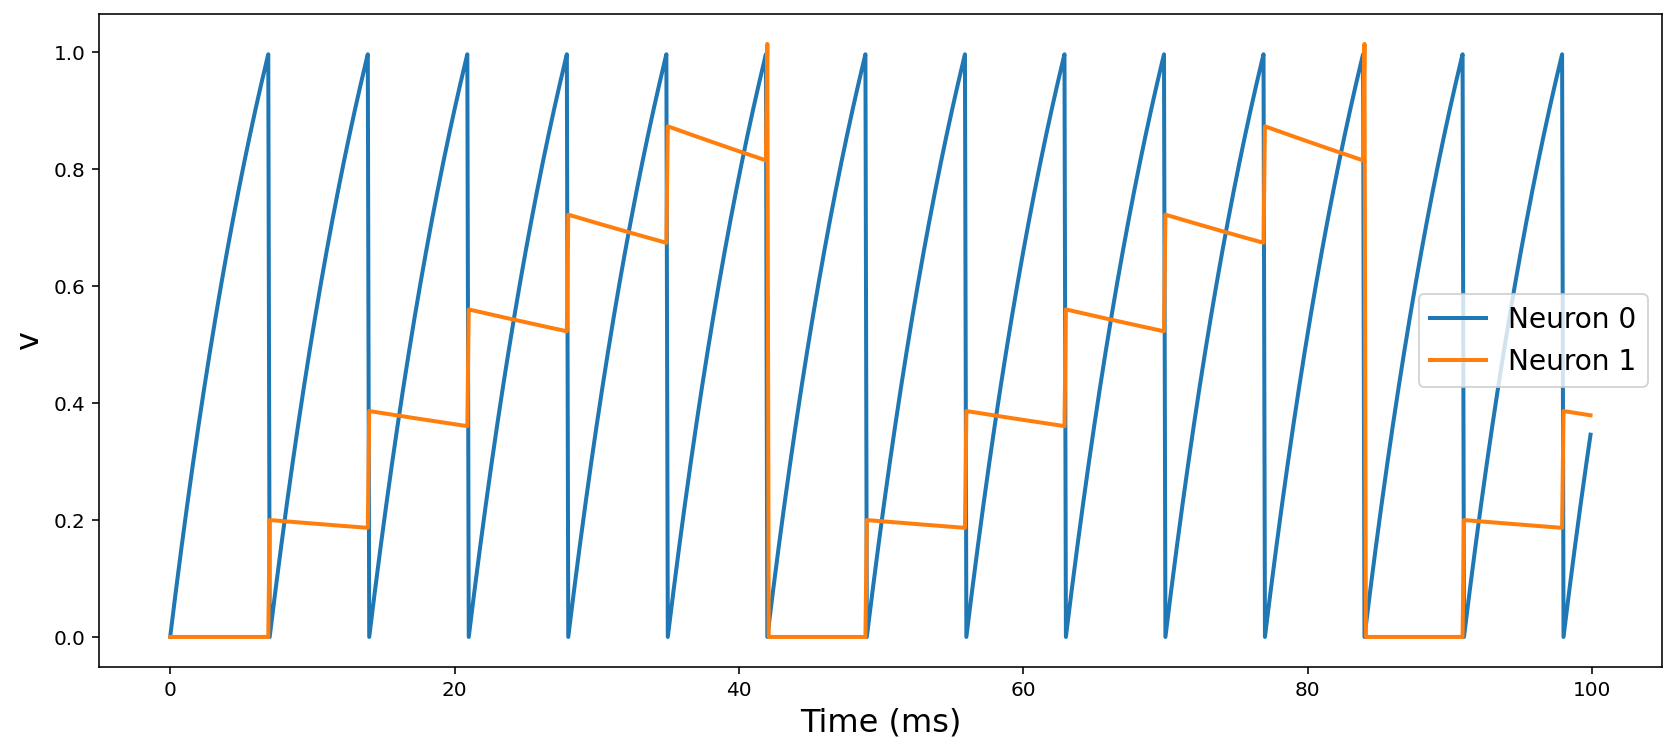

In [11]:
start_scope()

N = 2
eqs = '''
dv/dt = ((E_l - v) + I/g_l)/tau : 1
I : 1
tau : second
'''
G = NeuronGroup(N, eqs, threshold='v>V_thred', reset='v=V_rest', method='exact')
G.I = [1e-1, 0]
G.tau = [10, 100]*ms

# Comment these two lines out to see what happens without Synapses
S = Synapses(G, G, on_pre='v += 0.2')   # define synapses
S.connect(i=0, j=1)                     # create connections

M = StateMonitor(G, 'v', record=True)

run(100*ms)

figure(figsize=(14,6))
for idx in range(N):
    plot(M.t/ms, M.v[idx], label=f'Neuron {idx:d}')
xlabel('Time (ms)')
ylabel('v')
legend();

There are a few things going on here. First of all, let's recap what is going on with the ``NeuronGroup``. We've created two neurons, each of which has the same differential equation but different values for parameters I and tau. Neuron 0 has ``I=1e-1`` and ``tau=10*ms`` which means that is driven to repeatedly spike at a fairly high rate. Neuron 1 has ``I=0`` and ``tau=100*ms`` which means that on its own - without the synapses - it won't spike at all (the driving current I is 0). You can prove this to yourself by commenting out the two lines that define the synapse.

Next we define the synapses: ``Synapses(source, target, ...)`` means that we are defining a synaptic model that goes from ``source`` to ``target``. In this case, the source and target are both the same, the group ``G``. The syntax ``on_pre='v += 0.2'`` means that when a spike occurs in the presynaptic neuron (hence ``on_pre``) it causes an instantaneous change on postsynaptic neuron to happen ``v += 0.2``. So in total, what this model says is that whenever two neurons in G are connected by a synapse, when the source neuron fires a spike the target neuron will have its value of ``v`` increased by 0.2.

However, at this point we have only defined the synapse model, we haven't actually created any synapses. The next line ``S.connect(i=0, j=1)`` creates a synapse from neuron 0 to neuron 1.

### Adding weights and delays
In the previous section, we hard coded the weight of the synapse to be the value 0.2, but often we would to allow this to be different for different synapses. We do that by introducing synapse equations.

Also, we can change previous instantaneous synapses into delayed ones by introducing synaptic delays.

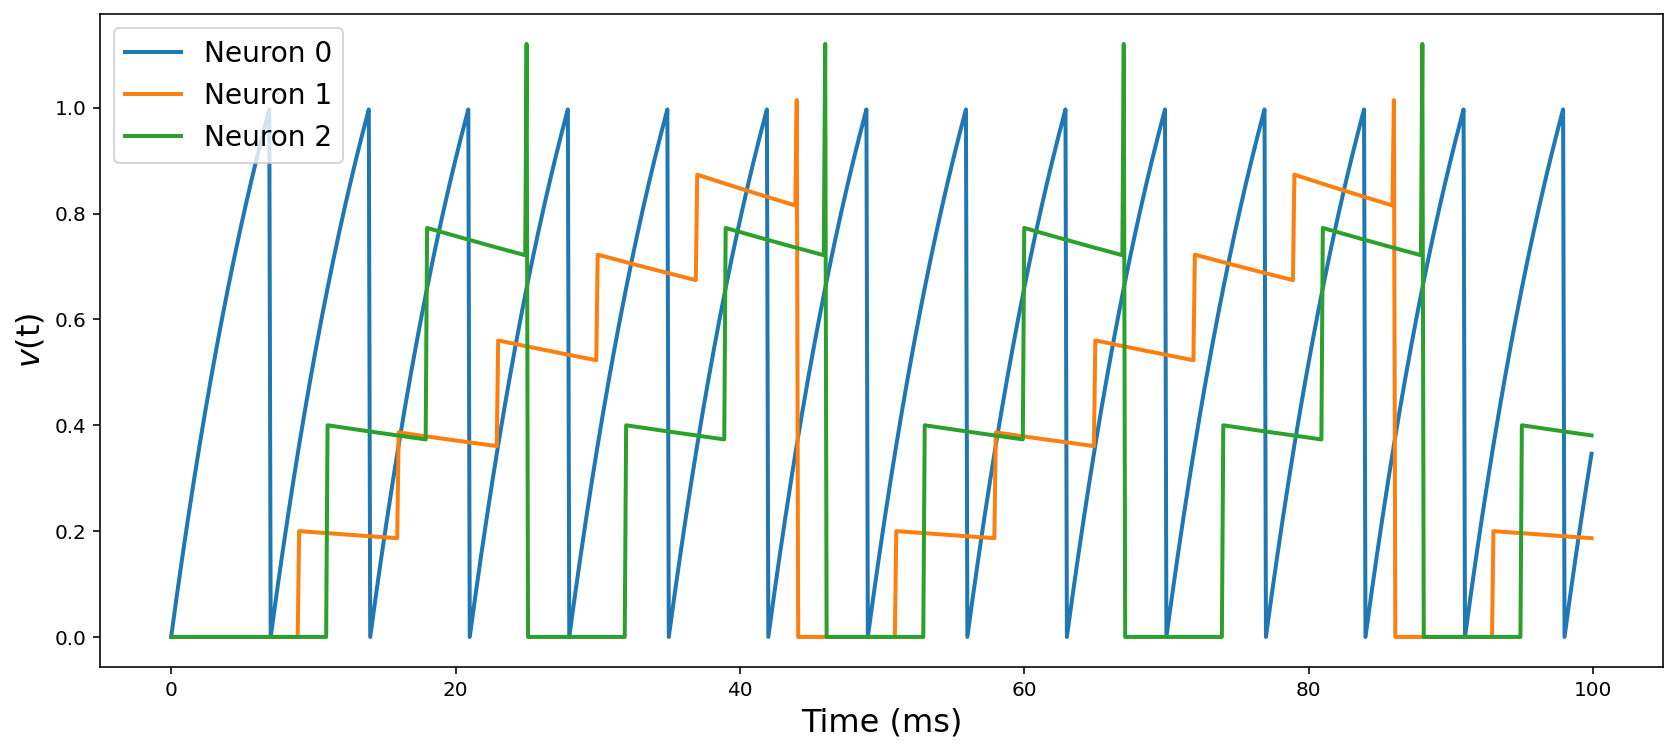

In [12]:
start_scope()

N = 3
eqs = '''
dv/dt = ((E_l - v) + I/g_l)/tau : 1
I : 1
tau : second
'''
G = NeuronGroup(3, eqs, threshold='v>V_thred', reset='v=V_rest', method='exact')
G.I = [1e-1, 0, 0]          # initialize external driving currents
G.tau = [10, 100, 100]*ms   # initialize time constants

# Comment these two lines out to see what happens without Synapses
S = Synapses(G, G, model='w:1', on_pre='v += w')
S.connect(i=0, j=[1, 2])
S.w = 'j*0.2'         # ADD WEIGHTS
S.delay = 'j*2*ms'    # ADD DELAYS

M = StateMonitor(G, 'v', record=True)

run(100*ms)

figure(figsize=(14,6))
for idx in range(N):
    plot(M.t/ms, M.v[idx], label=f'Neuron {idx:d}')
xlabel('Time (ms)')
ylabel(r'$v$(t)')
legend();

## More `Synapse.connect()` examples
```python
>>> S.connect(condition='i != j') # all-to-all but no self-connections
>>> S.connect(i=0, j=0) # connect neuron 0 to itself
>>> S.connect(i=np.array([1, 2]), j=np.array([2, 1])) # connect 1->2 and 2->1
>>> S.connect() # connect all-to-all
>>> S.connect(condition='i != j', p=0.1)  # Connect neurons with 10% probability, exclude self-connections
>>> S.connect(j='i', n=2)  # Connect all neurons to themselves with 2 synapses
>>> S.connect(j='k for k in range(i+1)') # Connect neuron i to all j with 0<=j<=i
>>> S.connect(j='i+(-1)**k for k in range(2) if i>0 and i<N_pre-1') # connect neuron i to its neighbours if it has both neighbours
>>> S.connect(j='k for k in sample(N_post, p=i*1.0/(N_pre-1))') # neuron i connects to j with probability i/(N-1)
```

## More complex connectivity

So far, we specified the synaptic connectivity explicitly, but for larger networks this isn't usually possible. For that, we usually want to specify some condition.

In [13]:
start_scope()

N = 10
G = NeuronGroup(N, 'v:1')
S = Synapses(G, G)
S.connect(condition='i!=j', p=0.2)

Here we've created a dummy neuron group of N neurons and a dummy synapses model that doens't actually do anything just to demonstrate the connectivity. The line ``S.connect(condition='i!=j', p=0.2)`` will connect all pairs of neurons ``i`` and ``j`` with probability 0.2 as long as the condition ``i!=j`` holds. So, how can we see that connectivity? Here's a little function that will let us visualise it.

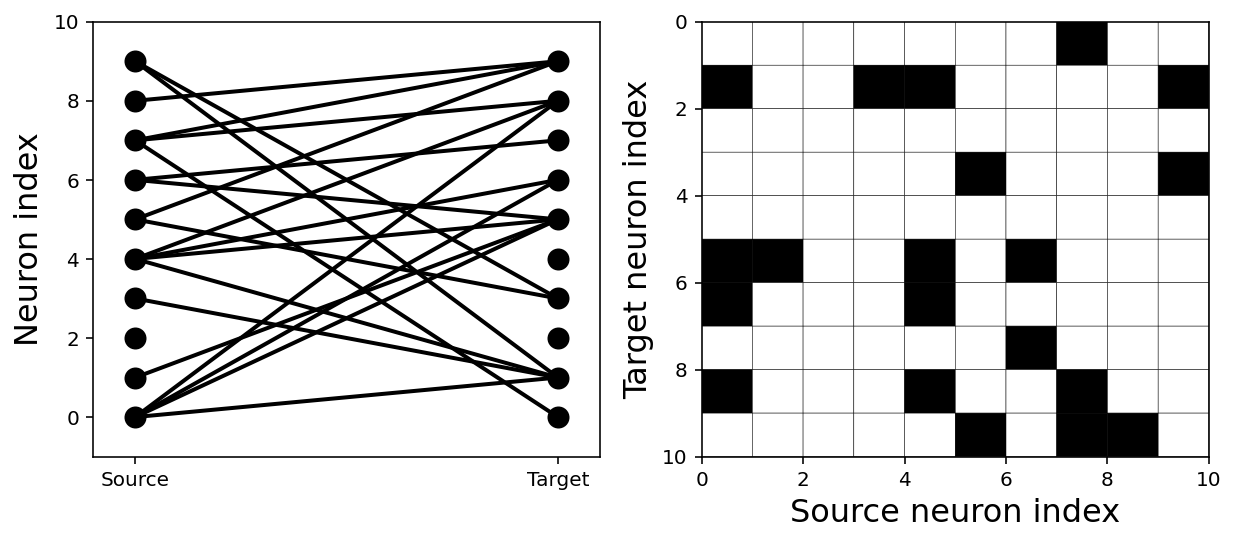

In [14]:
def visualise_connectivity(S:Synapses)->None:
    '''
    Visualize connectivity defined in Brian Synapses
    
    Args:
    S: Synapses object
    
    Returns:
    None
    
    '''
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    ax2 = plt.subplot(122)
    S_mat = np.ones((Nt, Ns))
    S_mat[S.j, S.i] = 0
    ax2.pcolor(S_mat, cmap='gray', edgecolor='k')
    ax2.invert_yaxis()
    ax2.set_xlabel('Source neuron index')
    ax2.set_ylabel('Target neuron index')
    
visualise_connectivity(S)

There are two plots here. On the left hand side, you see a vertical line of circles indicating source neurons on the left, and a vertical line indicating target neurons on the right, and a line between two neurons that have a synapse. On the right hand side is another way of visualising the same thing. Here each black dot is a synapse, with x value the source neuron index, and y value the target neuron index.

Let's see how these figures change as we change the probability of a connection:

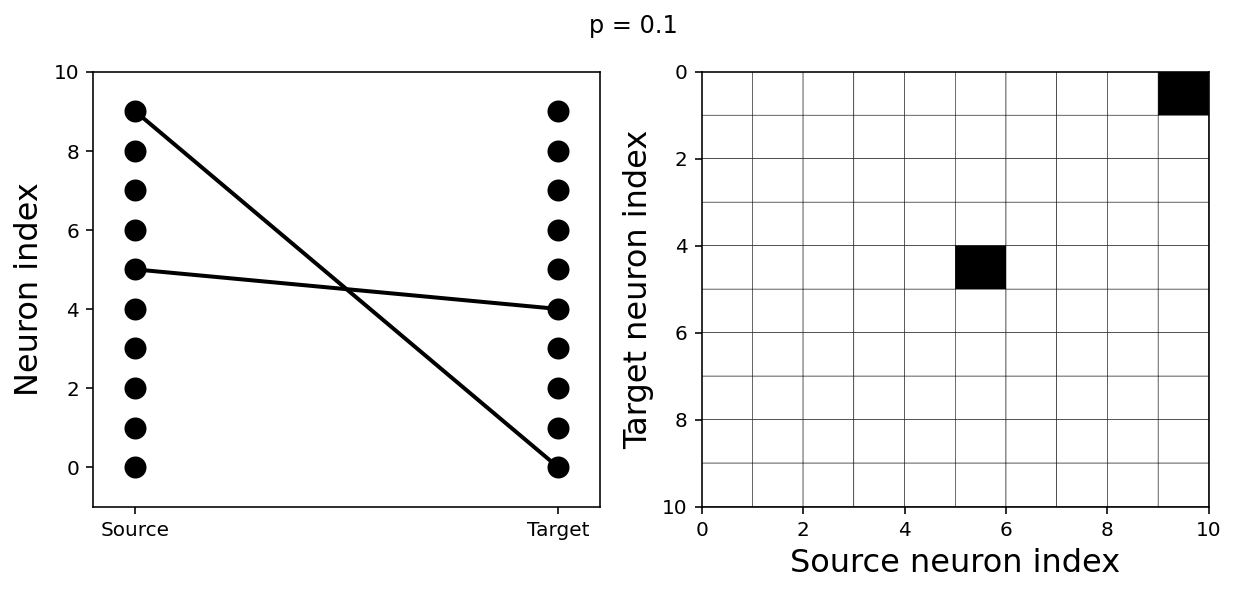

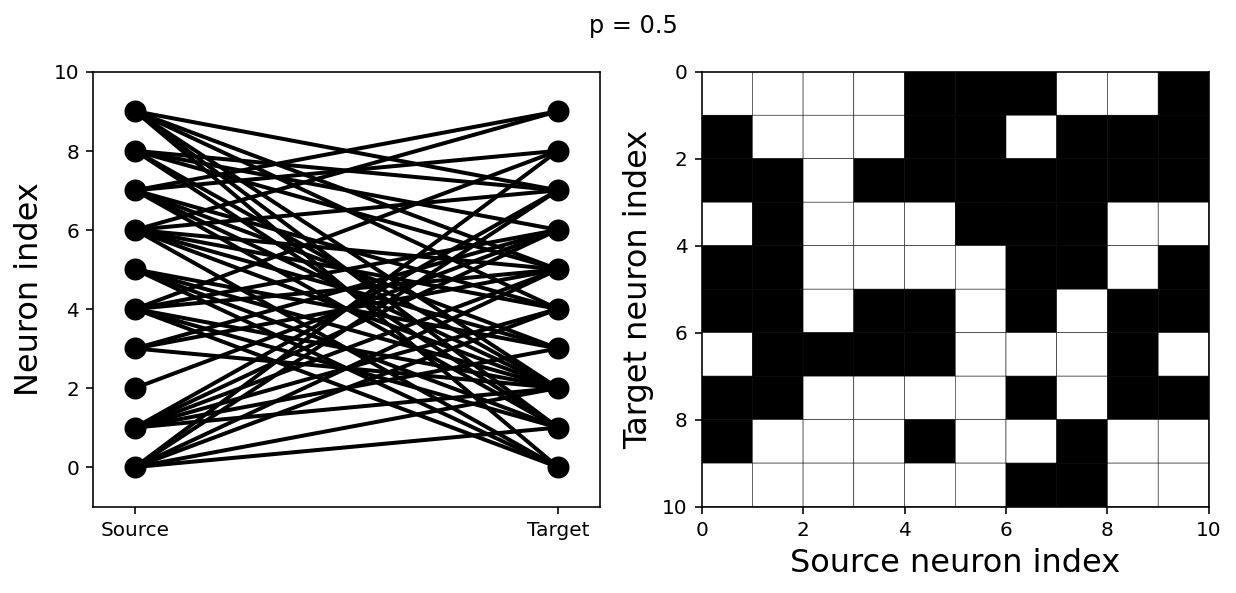

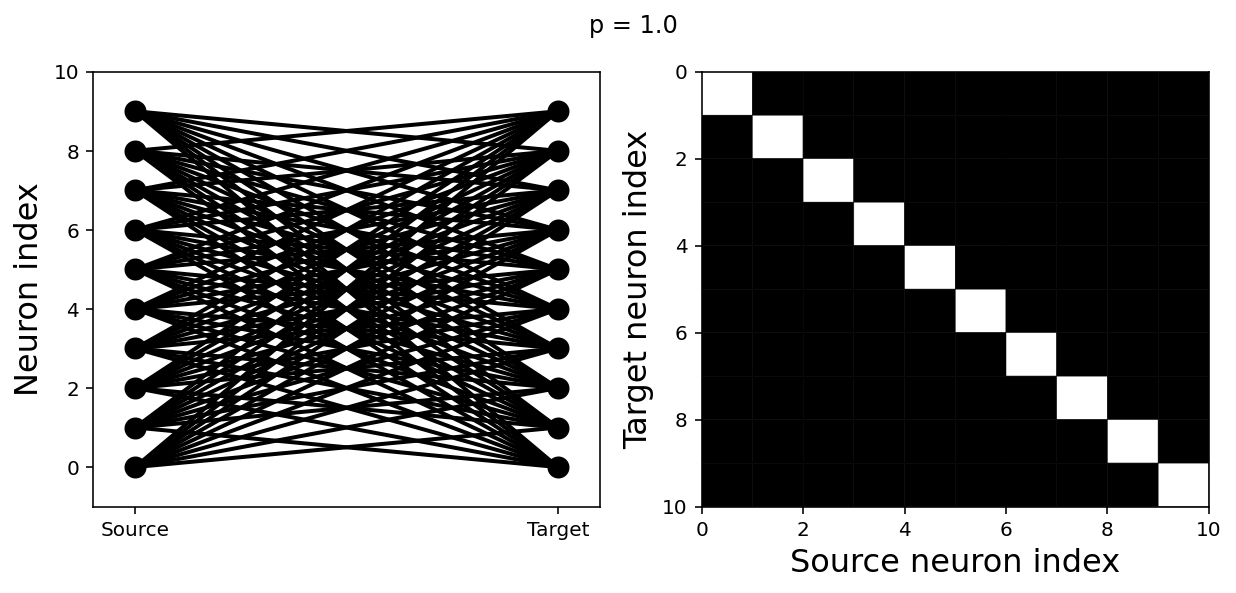

In [15]:
start_scope()

N = 10
G = NeuronGroup(N, 'v:1')

for p in [0.1, 0.5, 1.0]:
    S = Synapses(G, G)
    S.connect(condition='i!=j', p=p)
    visualise_connectivity(S)
    suptitle('p = '+str(p))

And let's see what another connectivity condition looks like. This one will only connect neighbouring neurons.

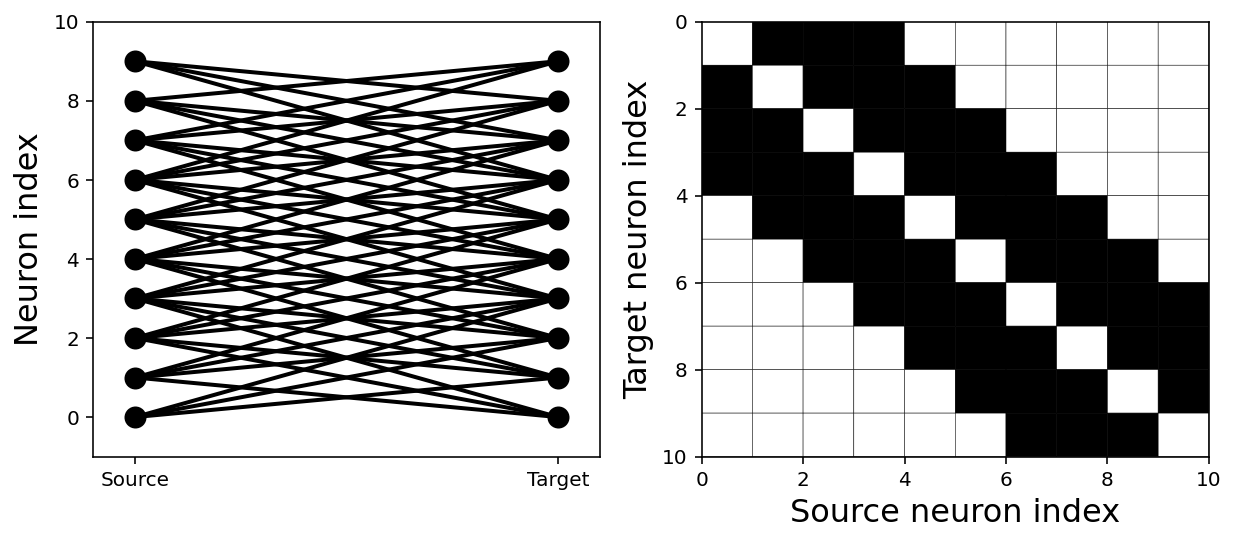

In [16]:
start_scope()

N = 10
G = NeuronGroup(N, 'v:1')

S = Synapses(G, G)
S.connect(condition='abs(i-j)<4 and i!=j')
visualise_connectivity(S)

If each source neuron is connected to precisely one target neuron (which would be normally used with two separate groups of the same size, not with identical source and target groups as in this example), there is a special syntax that is extremely efficient. For example, 1-to-1 connectivity looks like this:

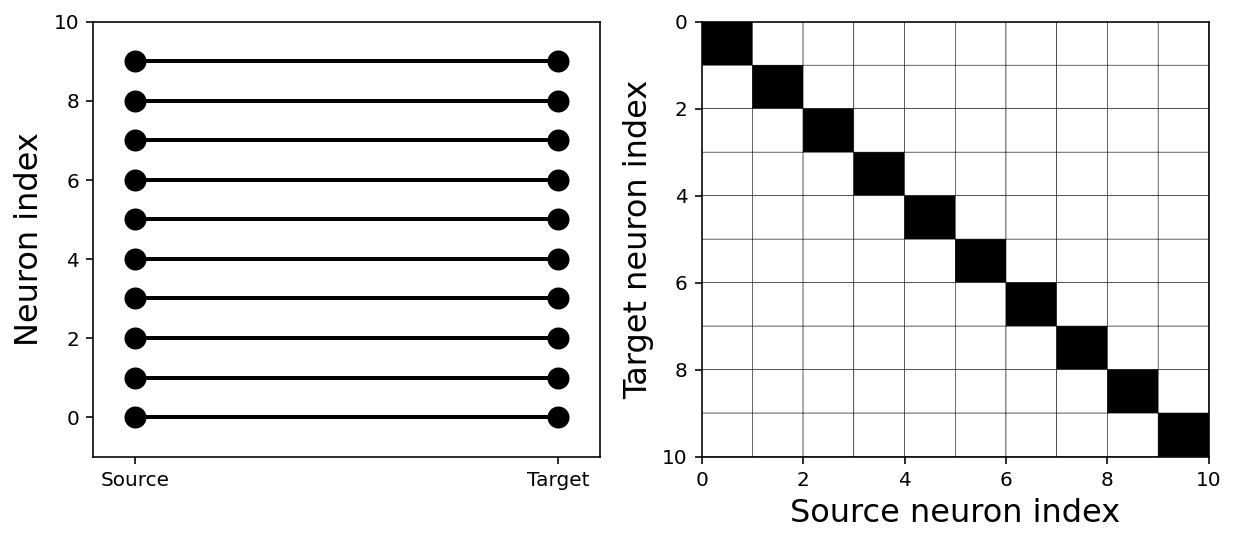

In [17]:
start_scope()

N = 10
G = NeuronGroup(N, 'v:1')

S = Synapses(G, G)
S.connect(j='i')
visualise_connectivity(S)

Eventually, we can combine the network and synapses all together to simulate a structured recurrent connected $\delta$-coupled LIF network!

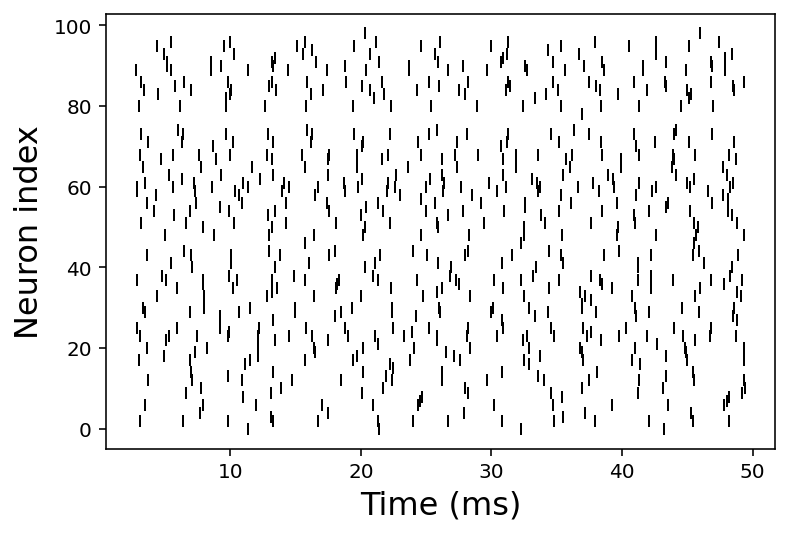

In [18]:
start_scope()

N = 100
tau_m = 10*ms
E_l = 0
V_thred = 1
V_rest  = 0
g_l = 0.05

eqs = '''
dv/dt = ((E_l - v) + I/g_l)/tau_m : 1
I : 1
'''

G = NeuronGroup(N, eqs, threshold='v>V_thred', reset='v=V_rest', method='euler')
S = Synapses(G,G, model='w:1', on_pre='v+=w')
S.connect(condition='i!=j', p=0.1)
I_max = 2e-1
G.I = 'I_max*rand()'
w_max=0.2
S.w = 'w_max*2*(rand()-0.5)'

spike_monitor = SpikeMonitor(G)

run(50*ms)

plot(spike_monitor.t/ms, spike_monitor.i, '|k')
xlabel('Time (ms)')
ylabel('Neuron index');

---
## Explore types of integrate-and-fire

### Current based LIF neuronal network

Model parameters are adapted from the reference below.

**Reference**:Simulation of networks of spiking neurons: A review of tools and strategies (2007). Brette, Rudolph, Carnevale, Hines, Beeman, Bower, Diesmann, Goodman, Harris, Zirpe, Natschlager, Pecevski, Ermentrout, Djurfeldt, Lansner, Rochel, Vibert, Alvarez, Muller, Davison, El Boustani and Destexhe. Journal of Computational Neuroscience 23(3):349-98

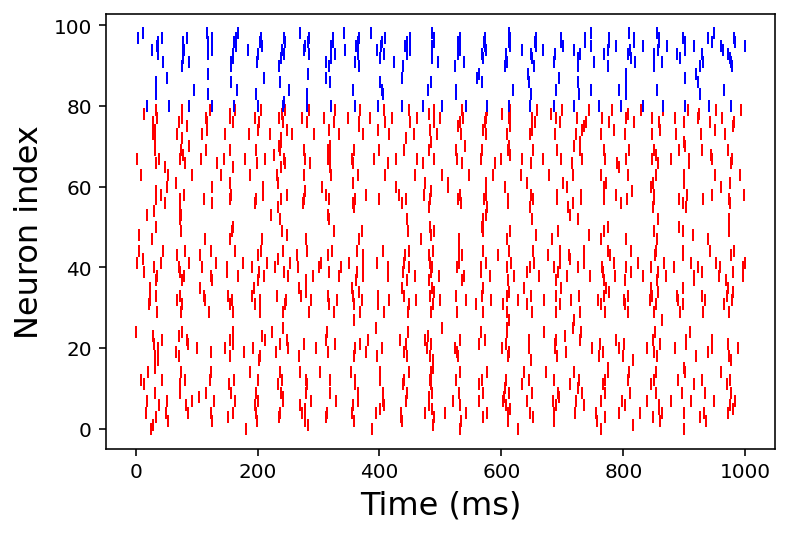

In [3]:
start_scope()

# Model parameter are adapted from: Simulation of networks of 
#   spiking neurons: A review of tools and strategies (2007). 
#   Brette, Rudolph, Carnevale, Hines, Beeman, Bower, Diesmann, 
#   Goodman, Harris, Zirpe, Natschlager, Pecevski, 
#   Ermentrout, Djurfeldt, Lansner, Rochel, Vibert, Alvarez,
#   Muller, Davison, El Boustani and Destexhe. 
#   Journal of Computational Neuroscience 23(3):349-98
N = 100
tau_m = 20*ms
tau_e = 5*ms
tau_i = 10*ms
V_thred = -50*mV
V_rest = -60*mV
E_l = -49*mV


eqs = '''
dv/dt = ((E_l - v) + Ie+Ii)/tau_m : volt (unless refractory)
dIe/dt = -Ie/tau_e : volt
dIi/dt = -Ii/tau_i : volt
'''

G = NeuronGroup(N, eqs, threshold='v>V_thred', reset='v=V_rest', refractory=2*ms, method='euler')
G.v = 'V_rest + rand() * (V_thred - V_rest)'
G.Ie = 0*mV
G.Ii = 0*mV

we = (60*0.27/10)*mV # excitatory synaptic weight (voltage)
wi = (-20*4.5/10)*mV # inhibitory synaptic weight
Se = Synapses(G,G, on_pre='Ie += we')
Si = Synapses(G,G, on_pre='Ii += wi')
Se.connect('i<80', p=0.1)
Si.connect('i>=80', p=0.1)

spike_monitor = SpikeMonitor(G)

run(1*second)

plot(spike_monitor.t[spike_monitor.i<80]/ms, spike_monitor.i[spike_monitor.i<80], '|r')
plot(spike_monitor.t[spike_monitor.i>=80]/ms, spike_monitor.i[spike_monitor.i>=80], '|b')
xlabel('Time (ms)')
ylabel('Neuron index');

We can investigate the statistics of the firing dynamics in this network.

In [4]:
def plot_isi(spk_mon:SpikeMonitor)->np.ndarray:
    '''
    Plot histogram of inter-spike interval(ISI) distribution of given spike trains.
    
    Args:
    spk_mon : SpikeMonitor object
    
    Returns:
    numpy.ndarray of ISI values.
    
    '''
    isi_array = np.array([])
    for idx in range(np.max(spike_monitor.i)+1):
        buffer = (spk_mon.t/ms)[spk_mon.i==idx]
        if len(buffer)>1:
            isi_array = np.append(isi_array, np.diff(buffer))
    plt.hist(isi_array, density=True, bins=20)
    plt.xlabel('ISI (ms)')
    plt.ylabel('Frequency')
    return isi_array

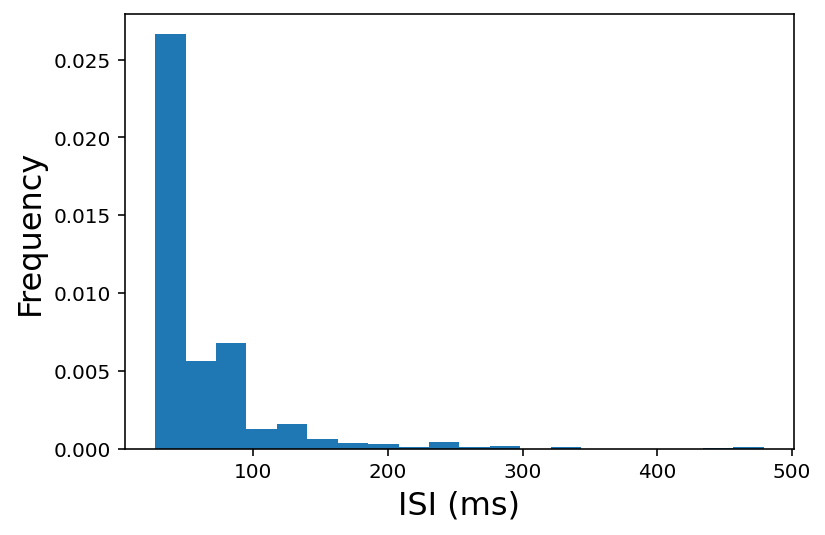

In [5]:
plot_isi(spike_monitor);

### Conductance-based LIF neuronal network

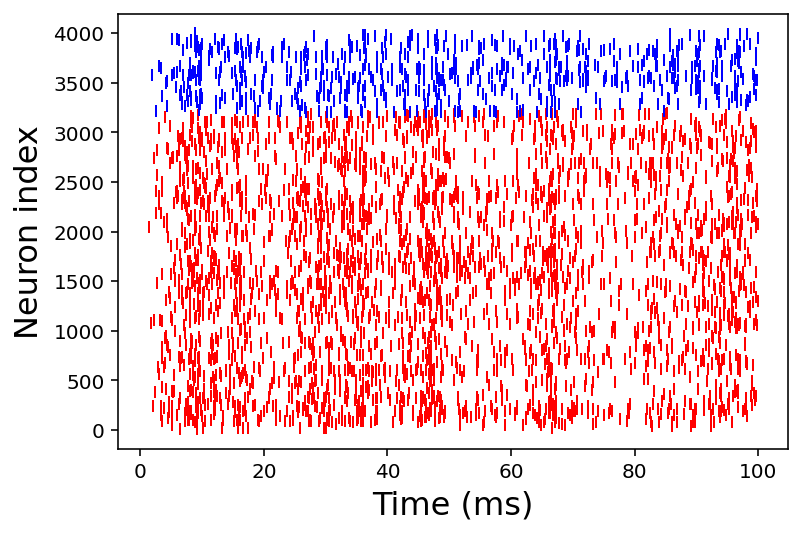

In [8]:
start_scope()

# Parameters
area = 20000*umetre**2
Cm = (1*ufarad*cm**-2) * area
gl = (5e-5*siemens*cm**-2) * area

tau_e = 5*ms
tau_i = 10*ms
V_thred = -40*mV
V_rest = -50*mV
E_l = -60*mV
E_e = 0*mV
E_i = -80*mV


eqs = '''
dv/dt = (gl * (E_l - v) + ge * (E_e - v) + gi * (E_i - v))/Cm : volt (unless refractory)
dge/dt = -ge/tau_e : siemens
dgi/dt = -gi/tau_i : siemens
'''

N = 4000
G = NeuronGroup(N, eqs, threshold='v>V_thred', reset='v=V_rest', refractory=2*ms, method='euler')

we = 6*nS  # excitatory synaptic weight
wi = 67*nS # inhibitory synaptic weight
Ge = G[:3200]
Gi = G[3200:]
Se = Synapses(Ge,G, on_pre='ge += we')
Si = Synapses(Gi,G, on_pre='gi += wi')
Se.connect(p=0.05)
Si.connect(p=0.065)

# initialization
seed(20210113)
G.v = 'E_l'
G.ge = '(randn() * 0.5 + 4) * 3.*nS'
G.gi = '(randn() * 12 + 20) * 3.*nS'


spike_monitor = SpikeMonitor(G)

run(100*msecond)

plot(spike_monitor.t[spike_monitor.i<3200]/ms, spike_monitor.i[spike_monitor.i<3200], '|r')
plot(spike_monitor.t[spike_monitor.i>=3200]/ms, spike_monitor.i[spike_monitor.i>=3200], '|b')
xlabel('Time (ms)')
ylabel('Neuron index');

## End of the Tutorial